In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
%matplotlib inline

### Gradient

In [2]:
"""
What is gradient? 
"""
print(__doc__)


What is gradient? 



In [3]:
def f(x):
    return 3*x**3 - 4*x*2 + 8

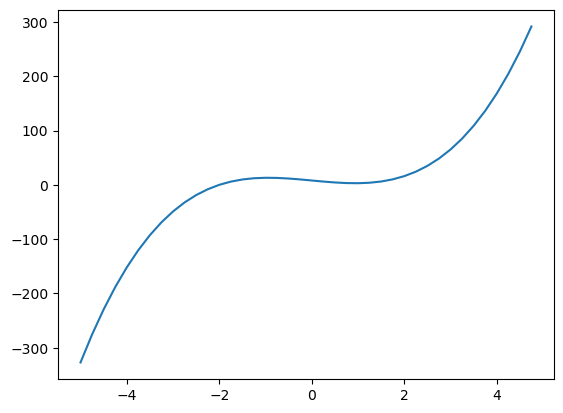

In [4]:
xs = np.arange(-5, 5, 0.25)
xy = f(xs)
plt.plot(xs, xy)

In [5]:
# generate gradient
h = 0.0000000001
x = 0
gradient = (f(x + h) - f(x))/h # normalize by h to get the slop
gradient

-8.000000661922968

In [6]:
# generate gradient
h = 0.0000000001
x = 1
gradient = (f(x + h) - f(x))/h
gradient

1.000000082740371

In [7]:
# generate gradient
h = 0.0000000001
x = 3
gradient = (f(x + h) - f(x))/h
gradient

73.00002380361548

In [8]:
# generate gradient
h = 0.0000000001
x = -3
gradient = (f(x + h) - f(x))/h
gradient

73.00002380361548

In [9]:
# let's go more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [10]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a += h
d2 = a*b + c

In [11]:
gradient = (d2 - d1) / h
gradient # derivation with respect to a which is b

-3.000000000064062

In [12]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

b += h
d2 = a*b + c

In [13]:
gradient = (d2 - d1) / h
gradient # derivation with respect to b which is a

2.0000000000131024

In [14]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h
d2 = a*b + c

In [15]:
gradient = (d2 - d1) / h
gradient # derivation with respect to c which is exact same amount which we added to c ==> 0.00001 / 0.00001 ~ 1

0.9999999999621422

### Lets build out the data structure for expressions

In [16]:
from dataclasses import dataclass, field

@dataclass
class Variable:
    data: float  # input data
    _children: set = field(default_factory=set)  # Store children as a set
    _prev: set = field(init=False, default_factory=set)  # Initialize as an empty set

    def __post_init__(self):
        for name, field_type in self.__annotations__.items():
            if not isinstance(getattr(self, name), field_type):
                current_type = type(getattr(self, name))
                raise TypeError(f"The field `{name}` was assigned by `{current_type}` instead of `{field_type}`")

        self._prev = self._children.copy()  # Use a copy of the set

    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        output = Variable(self.data + other.data, _children=self._children.union(other._children))  # Store children as a set
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        output = Variable(self.data - other.data, _children=self._children.union(other._children))  # Store children as a set
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        output =  Variable(self.data * other.data, _children=self._children.union(other._children))  # Store children as a set
        return output

    def __truediv__(self, other):
        """
        To true divide two Variable objects
        """
        output =  Variable(self.data / other.data, _children=self._children.union(other._children))  # Store children as a set
        return output


In [17]:
@dataclass
class Variable:
    data: float # input data
    _children: list = field(default_factory=list) # To keep track of all connections, basically to keep track of what variables are producing what Variables

    def __post_init__(self):
        for (name, field_type) in self.__annotations__.items():
            if not isinstance(self.__dict__[name], field_type):
                current_type = type(self.__dict__[name])
                raise TypeError(f"The field `{name}` was assigned by `{current_type}` instead of `{field_type}`")

        # self._prev = set(self._children)

    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        output = Variable(self.data + other.data, _children=[self, other])
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        output = Variable(self.data - other.data, _children=[self, other])
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        output =  Variable(self.data * other.data, _children=[self, other])
        return output

    def __truediv__(self, other):
        """
        To true divide two Variable objects
        """
        output =  Variable(self.data / other.data, _children=[self, other])
        return output

In [18]:
#!pip install graphviz

In [19]:
# code for visualisation of each function
from graphviz import Digraph
def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for children in v._prev:
                edges.add((children, v))
                build(children)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': "LR"}) # LR = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n)) # Return the identity of an object. This is guaranteed to be unique among simultaneously existing objects. (CPython uses the object's memory address.)
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operations, create an _op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    dot.attr(label=r'Forward Pass')
    dot.attr(fontsize='12')
                 
    return dot

In [93]:
class Variable:

    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        output =  Variable(self.data * other.data, _children=(self, other), _op = '*')
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')
        return output

    # def __truediv__(self, other):
    #     """
    #     To true divide two Variable objects
    #     """
    #     output =  Variable(self.data / other.data, _children=(self, other), _op = '/')
    #     return output

In [27]:
a = Variable(2.0, label='a')
b = Variable(-3.0, label='b')
c = Variable(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Variable(-2., label = 'f')
L = d * f; L.label = 'L'

In [28]:
d._prev

{Variable(data=-6.0), Variable(data=10.0)}

In [29]:
d._op

'+'

In [30]:
a + b

Variable(data=-1.0)

In [31]:
a.__add__(b)

Variable(data=-1.0)

In [32]:
a * b

Variable(data=-6.0)

In [33]:
a.__mul__(b)

Variable(data=-6.0)

In [34]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad * 1 #chain rule
e.grad = d.grad * 1 #chain rule
b.grad = e.grad * a.data #chain rule
a.grad = e.grad * b.data #chain rule

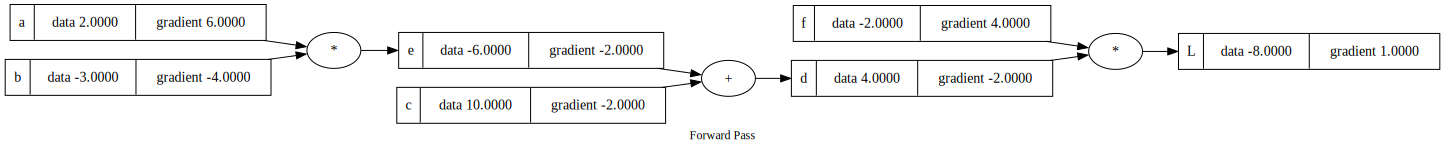

In [35]:
draw_dot(L)

In [36]:
# Try to nudge our inputs to try to make the output (L) to go up

a.data += 0.01 * a.grad  # if we want L to go up, that means we need to go in the direction of the gradient (a += ). Here we are incresing a by small step (learning rate = 0.01).
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad


# Then we do a forward pass

e = a * b
d = e + c

L = d * f # f is unchanged

### What has happened

We can see below that by changing a, b, c and d in the direction of the gradient, by adding to the them we have increased the final output. this can show the impact of the gradients on the final output

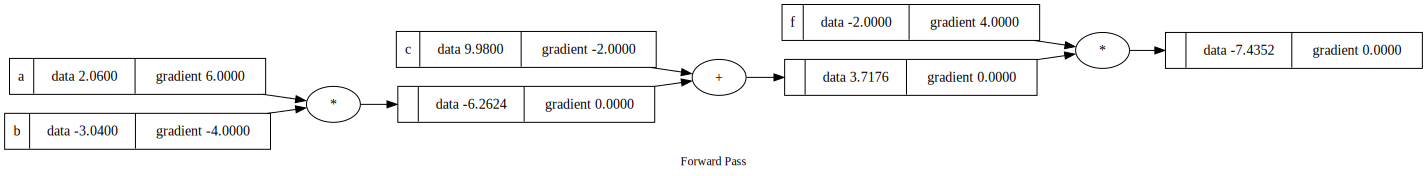

In [37]:
draw_dot(L)

### Backward Pass - Goal is to calculate the derivative of L with respect to each other Variable

In [38]:
def test():
    h = 0.001

    a = Variable(2.0, label='a')
    b = Variable(-3.0 + h, label='b')
    c = Variable(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    L1 = d * f; L1.label = 'L'

    a = Variable(2.0, label='a')
    b = Variable(-3.0, label='b')
    c = Variable(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    L2 = d * f; L1.label = 'L'

    print((L2.data - L1.data) / h)
    
test()

3.9999999999995595


## Example 2

In [39]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation
o = n.tanh(); o.label = 'o'

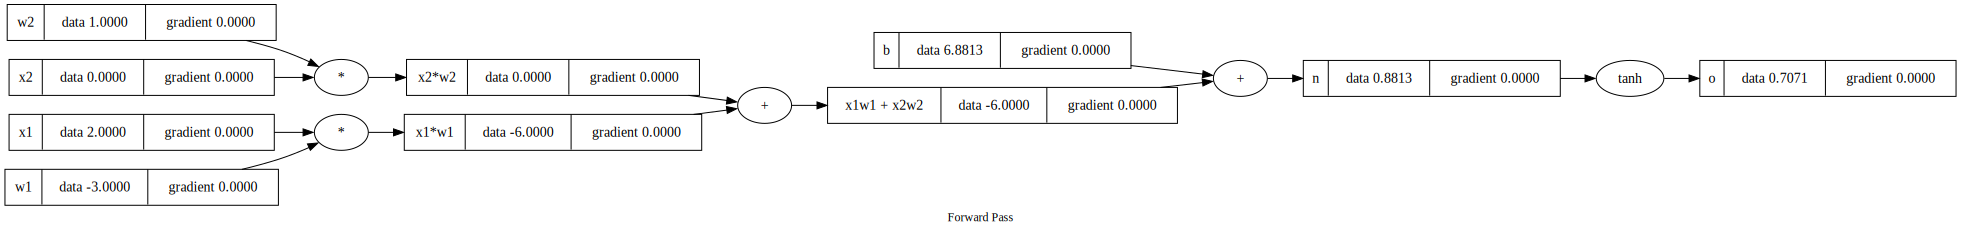

In [40]:
draw_dot(o)

In [41]:
o.grad = 1.
n.grad = 1 - o.data ** 2
b.grad = n.grad
x1w1x2w2.grad = n.grad * 1
x1w1.grad = x1w1x2w2.grad * 1
x2w2.grad = x1w1x2w2.grad * 1

w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

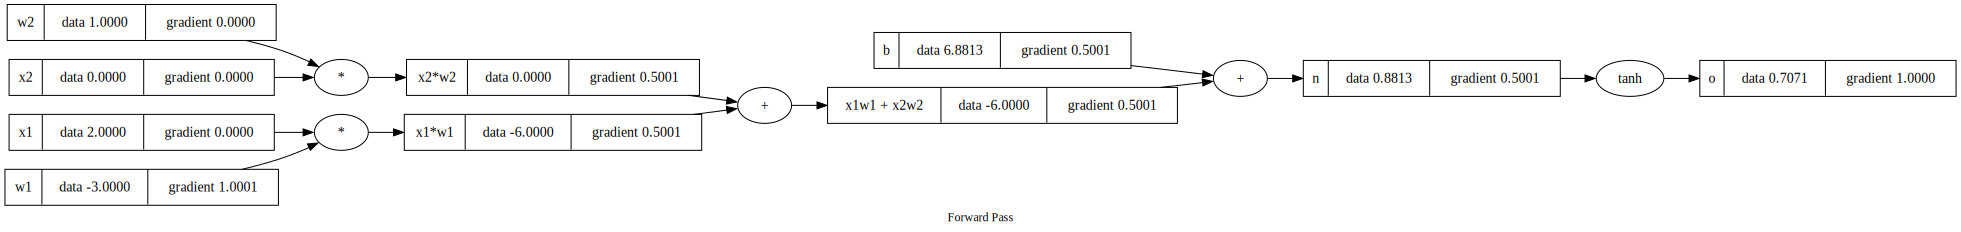

In [42]:
draw_dot(o)

### How to automate this gradient operation

In [43]:
class Variable:

    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad = 1.0 * output.grad
            other.grad = 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad = 1.0 * output.grad
            other.grad = 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        output =  Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad = other.data * output.grad
            other.grad = self.data * output.grad
            
        output._backward = _backward
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * output.grad

        output._backward = _backward        
        return output


In [44]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation
o = n.tanh(); o.label = 'o'

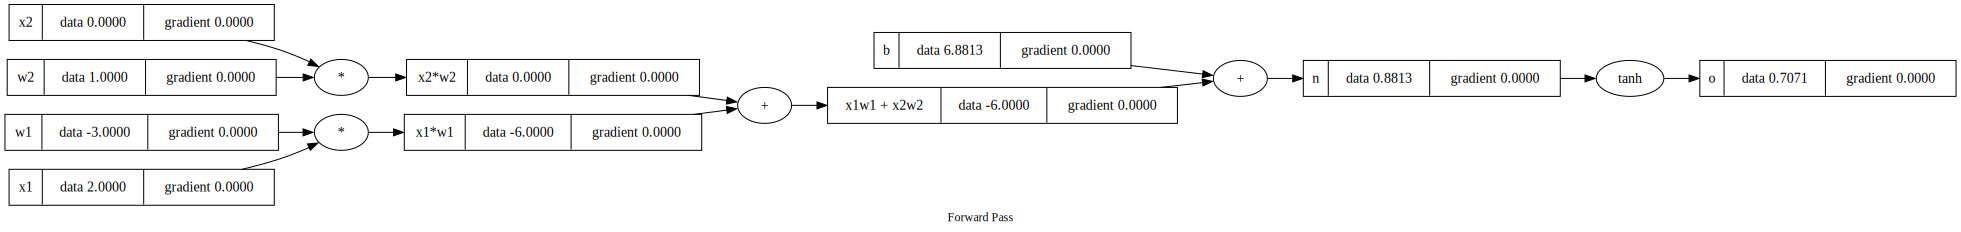

In [45]:
draw_dot(o)

In [46]:
o.grad = 1. # base case

In [47]:
o._backward()

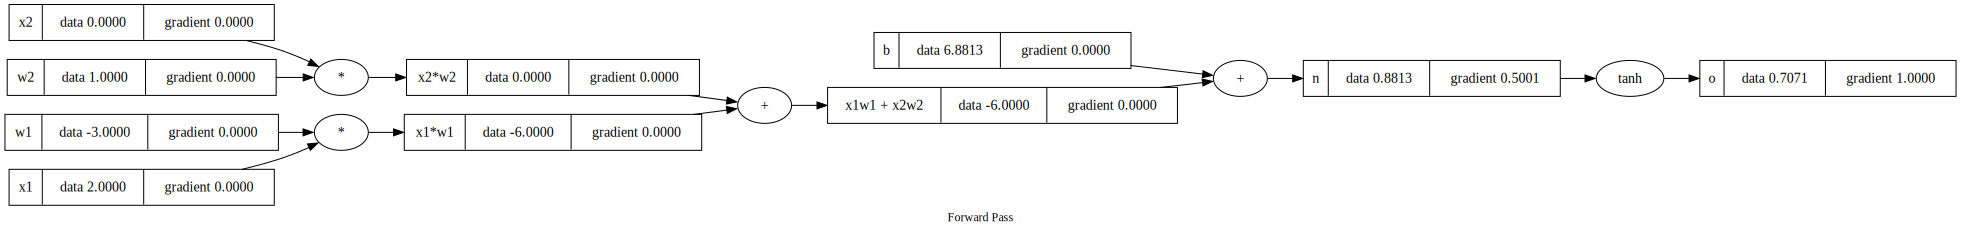

In [48]:
draw_dot(o)

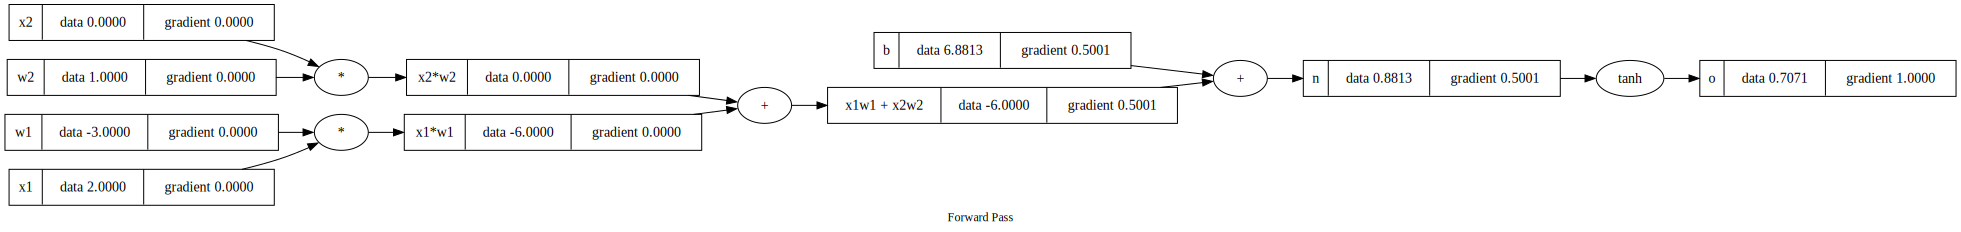

In [49]:
n._backward()
draw_dot(o)

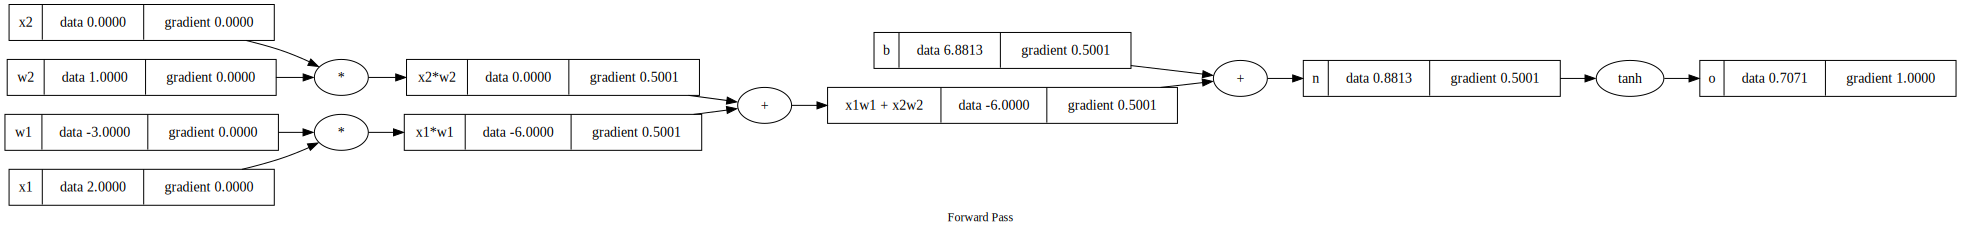

In [50]:
x1w1x2w2._backward()
draw_dot(o)

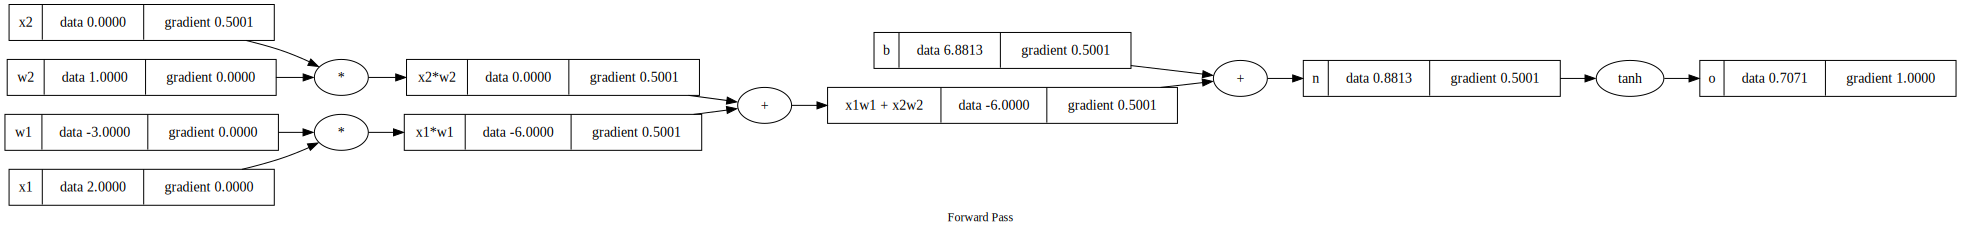

In [51]:
x2w2._backward()
draw_dot(o)

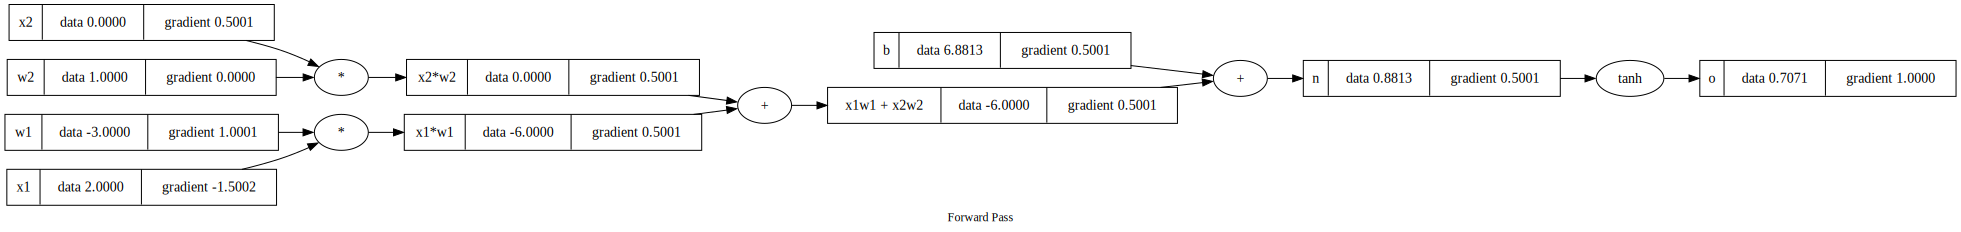

In [52]:
x1w1._backward()
draw_dot(o)

### Next to get remove the _backward manual call

In [53]:
"""
Topological sort:
The topological sort algorithm takes a directed graph and returns an array of the nodes where each node appears before all the nodes it points to.
The ordering of the nodes in the array is called a topological ordering.

All edges go only left to right - one way
"""

print(__doc__)


Topological sort:
The topological sort algorithm takes a directed graph and returns an array of the nodes where each node appears before all the nodes it points to.
The ordering of the nodes in the array is called a topological ordering.

All edges go only left to right - one way



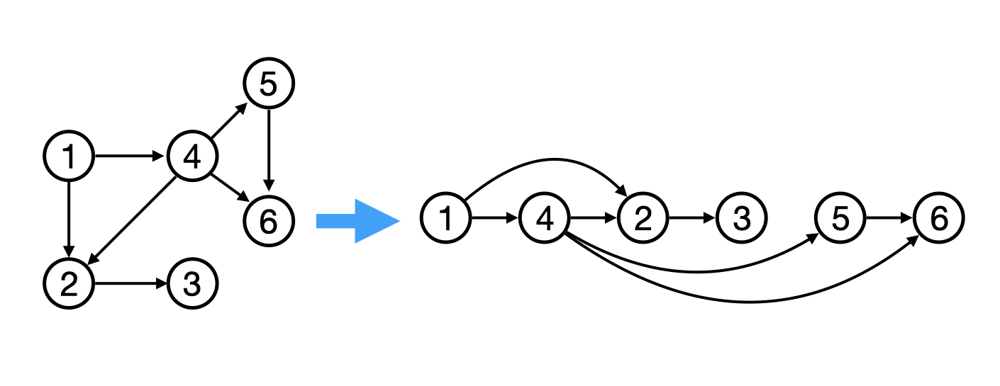

In [54]:
from IPython.display import Image, display
display(Image(filename='topological_sort.png'))

In [55]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation
o = n.tanh(); o.label = 'o'

o.grad = 1. # base case

In [56]:
topological_graph = []
visited_nodes = set()
def build_topological_graph(v):
    if v not in visited_nodes:
        visited_nodes.add(v)
        for child in v._prev:
            build_topological_graph(child)
        topological_graph.append(v)

build_topological_graph(o)

for node in reversed(topological_graph):
    node._backward()

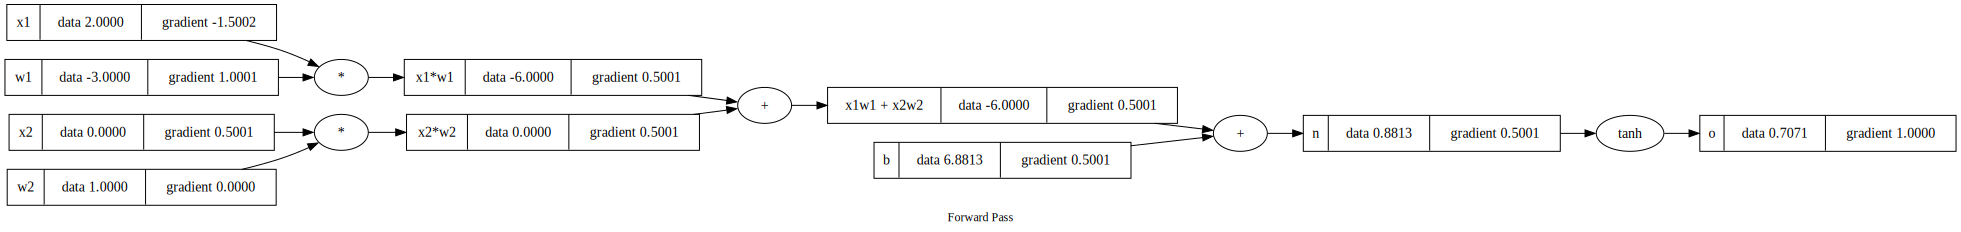

In [57]:
draw_dot(o)

In [58]:
class Variable:

    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad = 1.0 * output.grad
            other.grad = 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad = 1.0 * output.grad
            other.grad = 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        output =  Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad = other.data * output.grad
            other.grad = self.data * output.grad
            
        output._backward = _backward
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * output.grad

        output._backward = _backward        
        return output


    def backward(self):
        topological_graph = []
        visited_nodes = set()
        
        def build_topological_graph(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topological_graph(child)
                topological_graph.append(v)
        
        build_topological_graph(self)

        self.grad = 1.0
        for node in reversed(topological_graph):
            node._backward()
                


In [59]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation
o = n.tanh(); o.label = 'o'

In [60]:
o.backward()

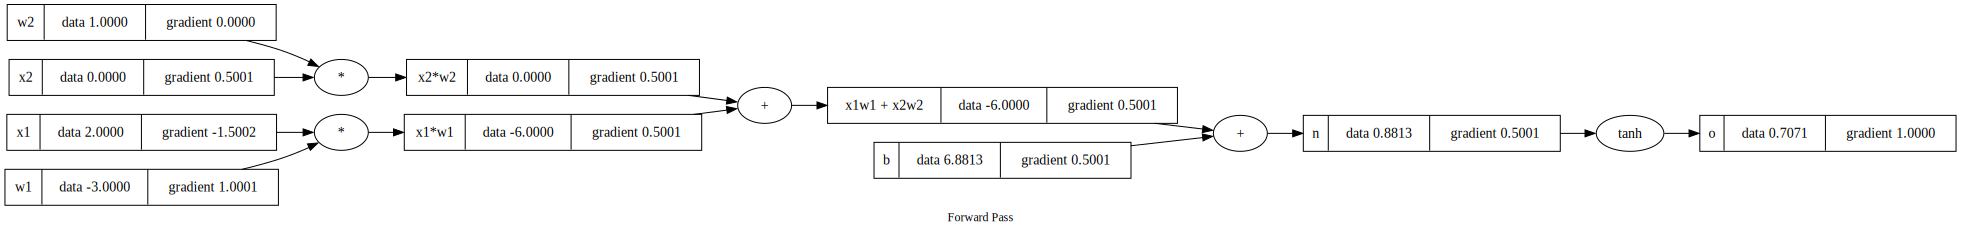

In [61]:
draw_dot(o)

### Ex:

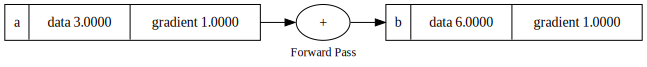

In [62]:
a = Variable(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
f = (a + b) * (a * b) = a^2 + 2ab + b^2 = 2a + 2b 

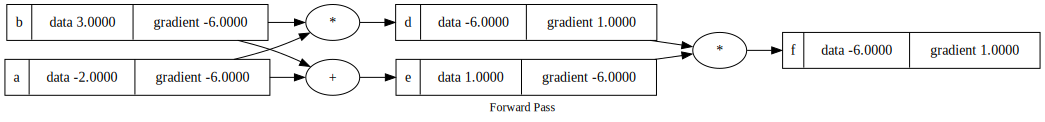

In [63]:
a = Variable(-2.0, label = 'a')
b = Variable(3.0, label = 'b')

d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

## what is the problem here:

In [404]:
"""
So far each variable only was used once, but as soon as a variable is used more than once the gradient will be wrong. Remember, 
we are setting the gradeient in a backward pass so if a was once reached to then the next time the gradeint will overwrite the value. 

also, in backward pass we only enter each node once.

Solution to this problem: Is multivariate case in the Chain-Rule https://en.wikipedia.org/wiki/Chain_rule

We need to accmulate this gradients, instead of setting them we should use +=
"""

print(__doc__)


So far each variable only was used once, but as soon as a variable is used more than once the gradient will be wrong. Remember, 
we are setting the gradeient in a backward pass so if a was once reached to then the next time the gradeint will overwrite the value. 

also, in backward pass we only enter each node once.

Solution to this problem: Is multivariate case in the Chain-Rule https://en.wikipedia.org/wiki/Chain_rule

We need to accmulate this gradients, instead of setting them we should use +=



In [64]:
class Variable:

    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output =  Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
            
        output._backward = _backward
        return output

    def __rmul__(self, other):
        """
        Python can not multiply other * self if other is simply a digit. Ex: 2 * Variable(4)
        so we define __rmul__ which by default will run if __mul__ operation was not possible. 
        """
        return self * other

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad

        output._backward = _backward        
        return output

    def exp(self):
        x = self.data
        output = Variable(math.exp(x), _children=(self, ), label='exp')

        def _backward():
            self.grad += output.grad * output.data
        output._backward = _backward
        return output
            

    def backward(self):
        topological_graph = []
        visited_nodes = set()
        
        def build_topological_graph(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topological_graph(child)
                topological_graph.append(v)
        
        build_topological_graph(self)

        self.grad = 1.0
        for node in reversed(topological_graph):
            node._backward()
                


### Ex:

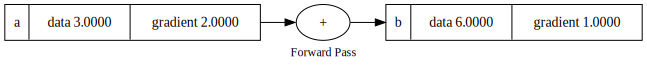

In [65]:
a = Variable(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

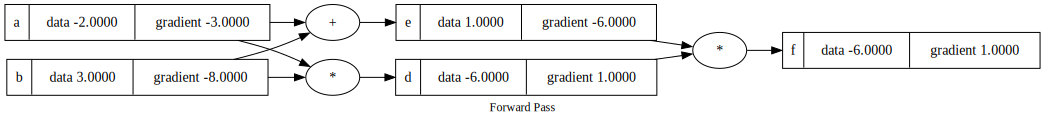

In [66]:
a = Variable(-2.0, label = 'a')
b = Variable(3.0, label = 'b')

d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

In [67]:
a = Variable(3, label='a')
2 * a

Variable(data=6)

In [68]:
a.exp()

Variable(data=20.085536923187668)

### Working on Division

* a / b
* a * (1/b)
* a * (b **-1)

In [69]:
class Variable:

    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __add__(self, other):
        """
        To add two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
            
        output._backward = _backward
        return output

    def __rmul__(self, other):
        """
        Python can not multiply other * self if other is simply a digit. Ex: 2 * Variable(4)
        so we define __rmul__ which by default will run if __mul__ operation was not possible. 
        """
        return self * other


    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        output = Variable(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
            
        output._backward = _backward
        return output            
            

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad

        output._backward = _backward        
        return output

    def exp(self):
        x = self.data
        output = Variable(math.exp(x), _children=(self, ), _op='exp')

        def _backward():
            self.grad += output.grad * output.data
        output._backward = _backward
        return output
            

    def backward(self):
        topological_graph = []
        visited_nodes = set()
        
        def build_topological_graph(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topological_graph(child)
                topological_graph.append(v)
        
        build_topological_graph(self)

        self.grad = 1.0
        for node in reversed(topological_graph):
            node._backward()
                


In [70]:
a = Variable(2, label='a')
b = Variable(4, label='b')
d = a / b

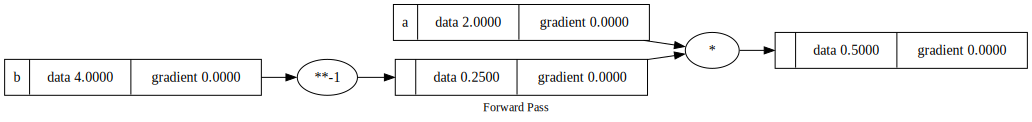

In [71]:
draw_dot(d)

In [72]:
d.backward()

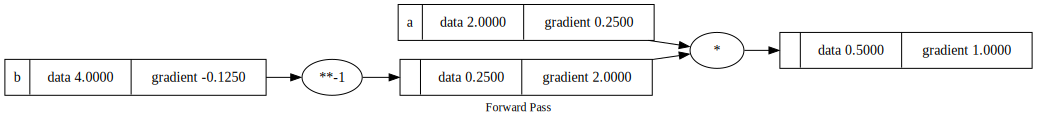

In [73]:
draw_dot(d)

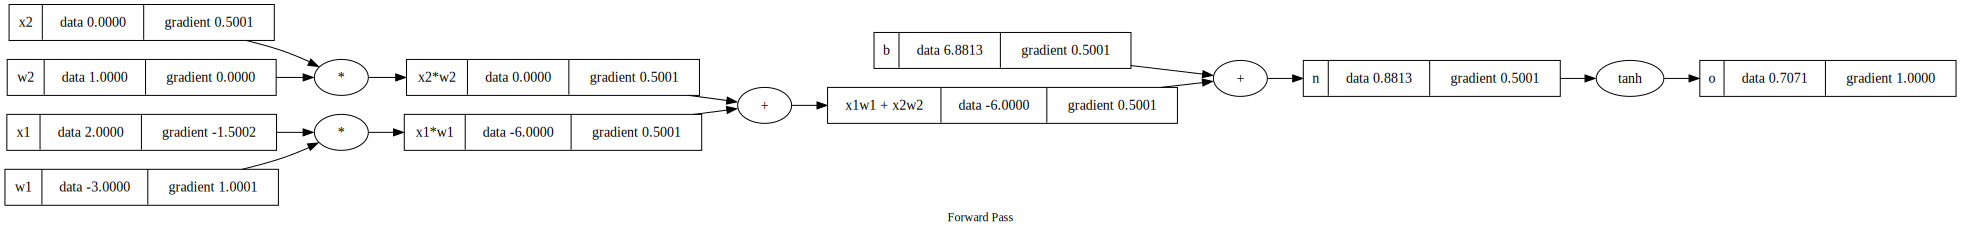

In [74]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

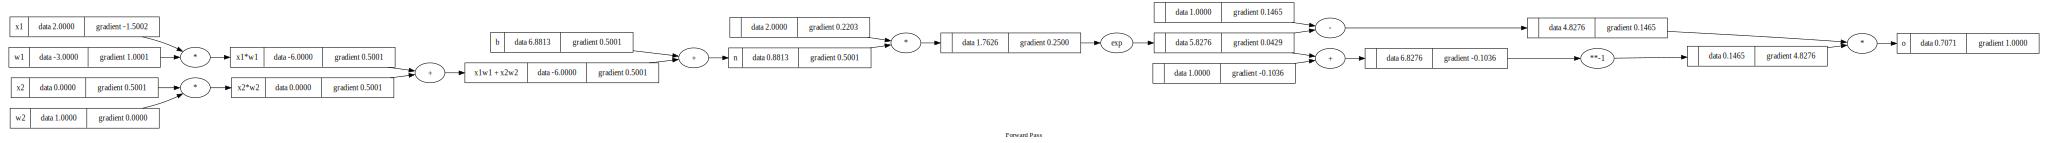

In [75]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # raw input to a neuron without activation

# -------
e = (2*n).exp()
o = (e - 1) / (e + 1) # Tanh
# -------
o.label = 'o'
o.backward()
draw_dot(o)

## Lets create Neurons

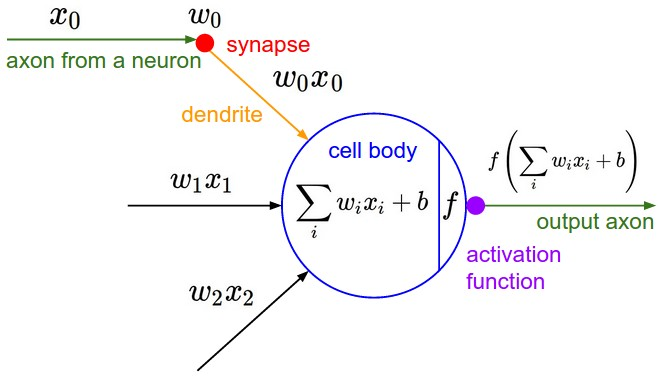

In [76]:
from IPython.display import Image, display
display(Image(filename='neuron.jpeg'))

In [77]:
import random

In [78]:
class Neuron:
    def __init__(self, input_d):
        """
        @input_d: int, number of inputs to a given neuron
        """
        self.w = [Variable(random.uniform(-1, 1)) for _ in range(input_d)]
        self.b = Variable(random.uniform(-1, 1))

    def __call__(self, x):
        """
        f(x) python will use __call__. 
        @x: list, input
        """
        act = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b)
        output = act.tanh()
        return output

In [79]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Variable(data=-0.783555340566551)

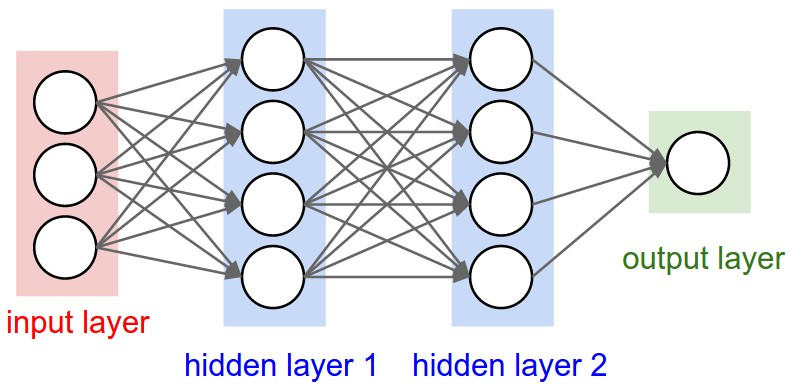

In [80]:
from IPython.display import Image, display
display(Image(filename='neural_net2.jpeg'))

In [81]:
class Layer:
    def __init__(self, neuron_dim, layer_dim):
        self.neurons = [Neuron(neuron_dim) for _ in range(layer_dim)]
        
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

In [82]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Variable(data=0.9226451406241464),
 Variable(data=0.9286529992121374),
 Variable(data=0.8086077905580685)]

In [83]:
class MLP:
    def __init__(self, input_dim, layers_dim):
        sizes = [input_dim] + layers_dim
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layers_dim))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [84]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Variable(data=-0.7799753778131874)

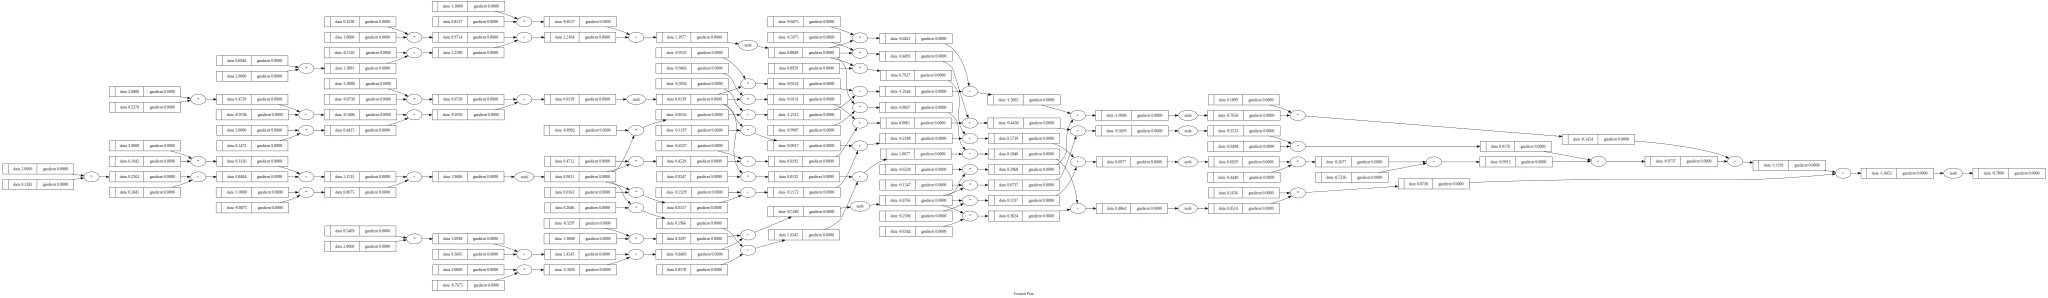

In [85]:
draw_dot(n(x))

In [86]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypreds = [n(x) for x in xs]

In [87]:
ypreds

[Variable(data=-0.7799753778131874),
 Variable(data=-0.8203285442055421),
 Variable(data=-0.7447920606247385),
 Variable(data=-0.634430973601955)]

In [88]:
loss = sum(((ypred - y)**2  for ypred, y in zip(ypreds, ys)), Variable(0))
loss 

Variable(data=5.9370898774381)

In [89]:
loss.backward()

In [90]:
n.layers[0].neurons[0].w[0].grad # positive grad means increasing this weight will decrease the cost

-0.005005401142923497

In [91]:
n.layers[0].neurons[0].w[0]

Variable(data=0.12817251701818244)

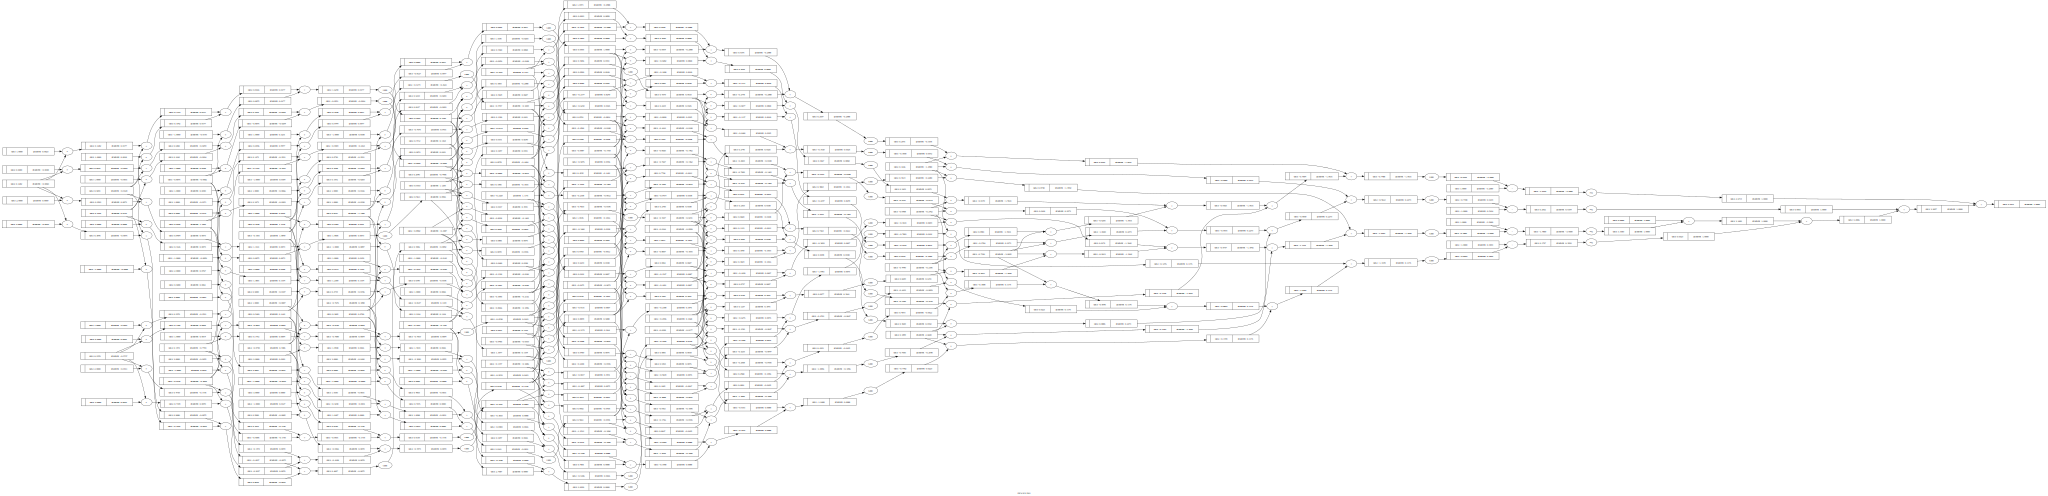

In [92]:
draw_dot(loss)

### Lets add functionality to get all the parameters

In [690]:
class Neuron:
    def __init__(self, input_d):
        """
        @input_d: int, number of inputs to a given neuron
        """
        self.w = [Variable(random.uniform(-1, 1)) for _ in range(input_d)]
        self.b = Variable(random.uniform(-1, 1))

    def __call__(self, x):
        """
        f(x) python will use __call__. 
        @x: list, input
        """
        act = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b)
        output = act.tanh()
        return output

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, neuron_dim, layer_dim):
        self.neurons = [Neuron(neuron_dim) for _ in range(layer_dim)]
        
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        params = [parameter for neuron in self.neurons for parameter in neuron.parameters()]
        return params

class MLP:
    def __init__(self, input_dim, layers_dim):
        sizes = [input_dim] + layers_dim
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layers_dim))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]


In [698]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Variable(data=0.1453940880723763)

In [699]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

for t in range(50):
    # Forward pass
    ypreds = [n(x) for x in xs]
    loss = sum(((ypred - y)**2  for ypred, y in zip(ypreds, ys)), Variable(0))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(t, loss.data)

0 2.384602801718121
1 1.6318825212230759
2 0.8088121739958916
3 0.41452385792521956
4 0.2923102136618497
5 0.2347283366388221
6 0.1948611337773373
7 0.16582272859862401
8 0.14384043829486987
9 0.12668399029109634
10 0.11295899704868165
11 0.10175317737365194
12 0.09244676253926531
13 0.08460513431046876
14 0.07791515209385802
15 0.07214587215661239
16 0.06712347589001172
17 0.06271478550153363
18 0.058816139500296724
19 0.05534570989114333
20 0.05223808592871704
21 0.04944038462151374
22 0.046909410751759036
23 0.044609551719005325
24 0.04251119552391369
25 0.04058952689548993
26 0.03882360058503262
27 0.037195620429523776
28 0.03569037299103364
29 0.03429477858832346
30 0.03299753238768924
31 0.03178881523687371
32 0.030660058984417034
33 0.02960375471472041
34 0.028613295046066634
35 0.027682843660218264
36 0.026807226749990257
37 0.02598184222073764
38 0.025202583359469753
39 0.024465774360727766
40 0.023768115621872067
41 0.023106637128990838
42 0.022478658575584662
43 0.0218817551

In [700]:
ypreds

[Variable(data=0.9411172562112263),
 Variable(data=-0.9678948829757281),
 Variable(data=-0.9080116007831649),
 Variable(data=0.9233002454211764)]